In [5]:
import numpy as np
import pandas as pd

import pickle
import re

import networkx as nx
import matplotlib.pyplot as plt
import plotly.express as px

#import osmnx as ox
#import geopandas as gpd
#import shapely.geometry

My dataset of the whole of Belfast is too big to experiment with graphing. As I'm mainly interested in Short Strand/Ballymacarrett, I decided derive a smaller and more focused dataset to work with.

Here's an overview of street directories hosted on LennonWylie:
* 1877: Earliest version with street intersections in sequence, Ballymacarrett combined with Belfast, but an additonal [street index](https://lennonwylie.co.uk/1877Appendix.htm#Street%20Index) sometimes notes if a street is in Ballymacarrett (or Mountpottinger) (approx 90 streets)
* 1868: Mountpottinger and Lagan Village are included in Ballymacarrett at https://lennonwylie.co.uk/ballymacarrett1868.htm, separately from Belfast. It includes 14 intersections and usually includes street parts (Rows, Terraces, Places) on their parent streets.
* 1861: Ballymacarrett is separate but mostly lacking intersection data (only four streets have it).
* 1852: Ballymacarrett is separate and has no intersection data but a lot of small rows.

I considered various ways of extracting the subset of data from the available sources, including:
* scraping the html of the 1868 edition with BeautifulSoup (there is slightly more context in the html than the text copy but not much as it uses non-hierarchical and non-standard formatting)
* editing my original extraction algorithm to make use of the "edge case" where extra lines after some street names indicate that the streets are in Ballymacarrett, storing this exta data to filter the dataset (ultimately unsuccessful, also due to inconsistent formatting)
* building a list of streets to filter for, based on data from the streets list in the 1877 directory, which is not separated by area but simpler in format.

The final option was ultimately the one that worked.

# Filter whole 1877 data based on area from separate street list

To filter the data, I first built a list of target streets (streets in the areas I am interested in) from the separate streets list in the directory. The streets list is not separated by areas in 1877 as it was in previous editions, but areas are often mentioned next to street names, albeit somewhat irregularly. Due to the simpler formatting, it is easier to use an algorithm to look for them based on a few rules including `target_areas = ['Mountpottinger', 'Ballymacarrett', 'Lagan Village']`. 

When I first tried to combine this new streets dataframe with my main data, I discovered that the main detection needed further refining, as most of the "edge cases" were in fact in my target data and were limiting its size and therefore usefulness. Once that was fixed, I was able to filter the main data based on my dataframe of target streets.

## Get street list as a DataFrame

From the streets list, I used some rules to detect which 1877 streets were in the target areas. These are stored in `df_ballymac_streets` along with the area and the adjoining street if these were detected.

There were a few more anomolies to solve in this stage:
* Streets names used as area names, e.g. `Memel Street, Bridge End`
* Consequently, streets with ambiguous street and area names, e.g. `Donegore Street, Bridge End, Ballymacarrett` vs `Graham's Place, Ballymacarrett, Bridge End` (Ballymacarrett/Ballymacarrett Road is listed in the main directory as a street in its own right, though doesn't have its own entry here. TODO: find name change)
* An error in which 'Short Strand' intersections are sometimes given as 'Short Street', which is a different street in Belfast, e.g. `Independent Street, Ballymacarrett, Short Street` (confirmed after some confusion by looking at a map).

In [87]:
def get_ballymac_streets(file_path_streetlist_txt):
    with open(file_path_streetlist_txt) as file:
        txt_file = file.readlines()

    df_street_gather = pd.DataFrame(columns=['street', 'area', 'second_street'])
    target_areas = ['Mountpottinger', 'Ballymacarrett', 'Lagan Village', 'Bridge End']
    
    # split the lines at commas into street, (area,) and second_street as df columns and append
    for line in txt_file:
        if ',' in line and any(area in line for area in target_areas):
            parts = line.split(',', 2)
            if len(parts) == 3:
                street, part1, part2 = map(str.strip, parts) # LATER: check usage of map(), found online

                if part1 in target_areas and part2 =='Ballymacarrett':
                    area, second_street = part2, part1
                elif part1 in target_areas and part2 in target_areas:
                    area, second_street = part1, part2
                elif part1 in target_areas:
                    area, second_street = part1, part2
                elif part2 in target_areas:
                    area, second_street = part2, part1
                else:
                    area, second_street = '', f"{part1}, {part2}"                
                df_street_gather.loc[len(df_street_gather)] = [street, area, second_street]
            
            elif len(parts) == 2:
                street, part1 = parts
                part1 = part1.strip()
                
                if part1 in target_areas:
                    area, second_street = part1, ''
                else:
                    area, second_street = '', part1                
                df_street_gather.loc[len(df_street_gather)] = [street.strip(), area, second_street]

    # clean up df abbreviations and errors to enable matching (LATER: clean this up!)
    for index, row in df_street_gather.iterrows():
        street = row['street'].replace('Terr.', 'Terrace')

        df_street_gather.at[index, 'street'] = street

        second_street_parts = row['second_street'].replace('Short Street', 'Short Strand').split()
        for i, part in enumerate(second_street_parts):
            if part.endswith(('Rd', 'Rd.')):
                second_street_parts[i] = part.replace('Rd', 'Road').replace('Rd.', 'Road')
            elif part == "N'Ards":
                second_street_parts[i] = "Newtownards"
        second_street = ' '.join(second_street_parts).replace('.', '')

        if second_street.endswith(('St', 'St.')) and len(second_street_parts) == 1:
            second_street = second_street[:-2] + 'Street'

        df_street_gather.at[index, 'second_street'] = second_street

        #detect three words ending 'Street' or 'Road' with the first word matching any of target_areas
        second_street_parts = second_street.split()
        if len(second_street_parts) == 3 and \
                second_street_parts[0] in target_areas and \
                second_street_parts[-1].endswith(('Street', 'Road')):
            area = second_street_parts[0]
            second_street = ' '.join(second_street_parts[1:])
            
            df_street_gather.at[index, 'area'] = area
            df_street_gather.at[index, 'second_street'] = second_street

        #add missing streets that appear only as second_street 
        if second_street:
            new_street = second_street[4:] if second_street.startswith('see ') else second_street
            new_second_street = '' if second_street.startswith('see ') else street
            if not (((df_street_gather['street'] == new_street) & (df_street_gather['second_street'] == new_second_street)).any() \
                    or ((df_street_gather['street'] == new_street) & (new_second_street == '')).any()):
                df_street_gather.loc[len(df_street_gather)] = [new_street, row['area'], new_second_street]
    
    # second pass
    for line in txt_file:
        if ',' in line and not ', The' in line and any(target_street in line for target_street in df_street_gather['street']):
            parts = line.split(',', 2)
            if len(parts) == 3:
                street, part1, part2 = map(str.strip, parts) # LATER: check usage of map(), found online

                if part1 in target_areas and part2 =='Ballymacarrett':
                    area, second_street = part2, part1
                elif part1 in target_areas and part2 in target_areas:
                    area, second_street = part1, part2
                elif part1 in target_areas:
                    area, second_street = part1, part2
                elif part2 in target_areas:
                    area, second_street = part2, part1
                else:
                    area, second_street = '', f"{part1}, {part2}"                
                df_street_gather.loc[len(df_street_gather)] = [street, area, second_street]
            
            elif len(parts) == 2:
                street, part1 = parts
                part1 = part1.strip()
                
                if part1 in target_areas:
                    area, second_street = part1, ''
                else:
                    area, second_street = '', part1                

        if not (df_street_gather['street'] == street).any():
            df_street_gather.loc[len(df_street_gather)] = [street, area, second_street]
        #TODO: maybe again add missing streets that appear only as second_street 
    #second clean    
    for index, row in df_street_gather.iterrows():
        street = row['street'].replace('Terr.', 'Terrace')

        df_street_gather.at[index, 'street'] = street

        second_street_parts = row['second_street'].replace('Short Street', 'Short Strand').split()
        for i, part in enumerate(second_street_parts):
            if part.endswith(('Rd', 'Rd.')):
                second_street_parts[i] = part.replace('Rd', 'Road').replace('Rd.', 'Road')
            elif part == "N'Ards":
                second_street_parts[i] = "Newtownards"
        second_street = ' '.join(second_street_parts).replace('.', '')

        if second_street.endswith(('St', 'St.')) and len(second_street_parts) == 1:
            second_street = second_street[:-2] + 'Street'

        df_street_gather.at[index, 'second_street'] = second_street

        #detect three words ending 'Street' or 'Road' with the first word matching any of target_areas
        second_street_parts = second_street.split()
        if len(second_street_parts) == 3 and \
                second_street_parts[0] in target_areas and \
                second_street_parts[-1].endswith(('Street', 'Road')):
            area = second_street_parts[0]
            second_street = ' '.join(second_street_parts[1:])
            
            df_street_gather.at[index, 'area'] = area
            df_street_gather.at[index, 'second_street'] = second_street
    
    
    return df_street_gather

# apply function to streets-only txt file 
df_ballymac_streets = get_ballymac_streets('./data/1877-BSD-streets-only')

df_ballymac_streets.to_csv('./data/df_ballymac_streets.csv')
df_ballymac_streets


,street,area,second_street
0,Abercorn Cottages,Ballymacarrett,
1,Albert Bridge Road,Mountpottinger,
2,Alfred Terrace,,see Mountpottinger Road
3,Ashley Lodge,Ballymacarrett,see Newtownards Road
4,Ashley Place,Mountpottinger,see Albert bridge Road
...,...,...,...
325,Willowfield,,see Woodstock Road
326,Willowfield Place,,see Woodstock Road
327,Woodstock Place,,Woodstock Road
328,Woodstock Street,,Albert Bridge Road


## Main data detection (new and improved)

The main extraction algorithm needed more rules adding to it to get around irregularities in the directory that disproportionately affected my target data. 

The main change fixed the detection of intersections that were not marked in the text by 'Off ' or ' to ' (for example in the instance of Baltic Street, where the initial 'street' line was followed with simply 'Bridge End, Ballymacarrett').

TODO: change this again? The street is sometimes used as an area and is not a true intersection, including in the given case! This step only shows generic node_info so can remain, but the following steps probably need to be altered again.

In [88]:
def bsd_txt_to_df_basic_nodes_2(txt_file_path):
    with open(txt_file_path) as file:
        txt_file = file.readlines()

    df_node_gather = pd.DataFrame(columns=['street', 'side', 'node_info', 'node_type'])
    current_street = node_info = ''
    i = 0 

    while i < len(txt_file):
        line = txt_file[i]
        next_line = txt_file[i + 1] if i + 1 < len(txt_file) else ''  # with EOF protection
        prev_line = txt_file[i - 1] if i - 1 >= 0 else ''

        # detect street renaming and skip
        if line.strip() == '' or line.startswith('[Late ') or line.startswith('(Late '):
            i += 1
            continue

        # crude detect lines only denoting side of street even when not directly under street
        if ']' in line:
            side = line.strip()
            i += 1
            continue
        
        # TODO: fix dots not being removed.
        # store explicit intersections as nodes and mark them as such
        if 'intersect' in line.lower():
            node_info = line.strip(".").replace(' intersects', '').replace(' intersect', '').replace('\n', '')
            node_type = 'intersect'
        else:
            # detect street header based on line and next line contents
            if prev_line.strip() == '' and len(line.split()) < 5 and not '[' in line and not ' to ' in line and not 'intersect' in line \
                and not any(char.isdigit() for char in line) and not "__" in line\
                and (' to ' in next_line or next_line.startswith('Off ') or next_line.startswith('From ') or '[' in next_line 
                     or 'Road' in next_line or 'Street' in next_line or ', Ballymacarrett' in next_line or next_line.strip() == 'Mountpottinger' 
                     or next_line.strip() == 'Ballymacarrett' or next_line.strip() == '') \
                and not 'door to' in next_line and not '.......' in next_line and not 'entrance to' in next_line.lower():

                    current_street = line.strip().replace(', Ballymacarrett', '')
                    side = ''  # reset side when beginning a new street
                    
                    # solve extra line for district or side: skip it and get node info from line below
                    if next_line.strip() == 'Mountpottinger' or next_line.strip() == 'Ballymacarrett': 
                        next_line = txt_file[i + 2]
                        i += 1
                    elif ']' in next_line:
                        side = next_line.strip()
                        next_line = txt_file[i + 2]
                        i += 1

                    i += 1  # increment i an extra time to avoid processing next_line a second time as line

            # detect sub-streets
            if next_line.strip().startswith('See '):
                current_street = next_line.strip().replace('See ', '').replace(', Ballymacarrett', '')
                node_info = line.strip().replace(', Ballymacarrett', '')
                node_type = 'sub-street'

            # otherwise look for from-to info (also store 'off' as from-to for now, and process it later)
            elif (' to ' in next_line or next_line.strip().startswith('Off ') or next_line.strip().startswith('From ') \
                or 'Road' in next_line or 'Street' in next_line) \
                and not 'door to' in next_line and not 'entrance to' in next_line.lower() \
                and not any(char.isdigit() for char in line):
                node_info = next_line.strip()
                node_type = 'from-to'

            # store next lines that may be an intersecting street or may just mean the vicinity of a street
            elif next_line.strip().endswith(', Ballymacarrett'):
                node_info = next_line.strip().replace(', Ballymacarrett', '')
                node_type = 'vicinity'

            else:
                node_info = line.strip()

        df_node_gather.loc[len(df_node_gather)] = {
            'street': current_street,
            'side': side,
            'node_info': node_info,
            'node_type': node_type
        }

        # reset per-record variables and increment
        node_info = node_type = ''
        i += 1

    return df_node_gather

df_basic_nodes_2 = bsd_txt_to_df_basic_nodes_2('./data/1877-BSD')


In [8]:
df_basic_nodes_2.to_csv('./data/df_basic_nodes_2.csv')

Now I need to carry out some transformation steps to derive a dataframe `df_nodes_2` with the node data properly separated into columns, modifying my prevous approach based on the format of the new data gathered in `df_basic_nodes_2`. 

In [89]:
# distinguish different types of street connections (ignoring sub-street and vicinity for now)
df_connections = df_basic_nodes_2[df_basic_nodes_2['node_type'].isin(['intersect', 'from-to'])][['street', 'node_type', 'node_info']]
df_connections[['from', 'to']] = df_connections['node_info'].str.split(' to ', n=1, expand=True)
df_connections['from'] = df_connections['from'].str.replace('Off ', '')
df_connections['node_type'] = df_connections.apply(lambda row: 'off' if row['node_info'].startswith('Off ') else row['node_type'], axis=1)
df_nodes_2 = df_basic_nodes_2.join(df_connections[['node_type', 'from', 'to']], lsuffix='_old')
df_nodes_2.drop(columns=['node_type_old'], inplace=True)

# add an extra flipped from-to node at the end of each street group
def add_second_from_to_node(grouped_street):
    if 'from-to' in grouped_street['node_type'].values:
        from_to_row = grouped_street[grouped_street['node_type'] == 'from-to'].iloc[0].copy()
        from_to_row['from'] = None
        from_to_row['node_type'] = 'from-to-inverse'
        grouped_street.loc[grouped_street['node_type'] == 'from-to', 'to'] = None
        grouped_street = pd.concat([grouped_street, from_to_row.to_frame().transpose()], ignore_index=True)
    return grouped_street

df_nodes_2 = df_nodes_2.groupby('street').apply(add_second_from_to_node).reset_index(drop=True)

# also store the intersecting street (from either 'from' or 'to') in a new unified single column
df_nodes_2['second_street'] = df_nodes_2['from'].combine_first(df_nodes_2['to'])
# add a step to deal with non-street info after a comma (eg area), but retain unnamed or multiple streets
df_nodes_2['second_street'] = df_nodes_2['second_street'].apply(lambda x: x.split(',')[0] if isinstance(x, str) \
                                                                and 'named' not in x and ' and ' not in x else x)

# get rows with multiple streets in 'second_street' and split to list values
df_nodes_test_2 = df_nodes_2.copy()
df_multi_streets = df_nodes_test_2[df_nodes_test_2['second_street'].fillna('').str.contains(' and ')].copy()
df_multi_streets['second_street'] = df_multi_streets['second_street'].str.split(' and |, ')

# rename street items ending in "Streets"
def process_list(lst):
    return [item.replace(" Streets", "").strip() + " Street" for item in lst]

df_multi_streets['second_street'] = df_multi_streets['second_street'].apply(lambda x: process_list(x) if any(" Streets" in item for item in x) else x)

# iterate through 'multi' rows and derive new separate rows
new_rows = []
for index, row in df_multi_streets.iterrows():
    for street in row['second_street']:
        new_row = row.copy()
        new_row['second_street'] = street
        new_rows.append(new_row)

# drop original 'multi' street rows from main data set
df_nodes_test_2.drop(df_multi_streets.index, inplace=True)

# convert new rows to a df and concat with main data set
new_df = pd.DataFrame(new_rows)
df_nodes_test_2 = pd.concat([df_nodes_test_2, new_df]) #, ignore_index=True

# sort by index to ensure sequential order then reset
df_nodes_test_2.sort_index(inplace=True)
df_nodes_test_2.reset_index(inplace=True, drop=True)

df_nodes_2 = df_nodes_test_2.copy()
df_nodes_2

/tmp/ipykernel_78527/1252220233.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_nodes_2 = df_nodes_2.groupby('street').apply(add_second_from_to_node).reset_index(drop=True)


,street,side,node_info,node_type,from,to,second_street
0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,None,North King Street
1,Abbey Street,,"1. Donaldson, Wm.",NaN,NaN,NaN,NaN
2,Abbey Street,,"3. Craggan, John, musician",NaN,NaN,NaN,NaN
3,Abbey Street,,"5. Ireland, Alex., flax dresser",NaN,NaN,NaN,NaN
4,Abbey Street,,"7. Long, John",NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
38992,Zetland Street,,"8. Clarke, James, her Majesty's Court of Probate",NaN,NaN,NaN,NaN
38993,Zetland Street,,"6. Morrow, Mrs.",NaN,NaN,NaN,NaN
38994,Zetland Street,,"4. Lynas, Joseph, boot maker",NaN,NaN,NaN,NaN
38995,Zetland Street,,"2. Fleming, James, insurance agent",NaN,NaN,NaN,NaN


The data in `df_nodes_2` needs to be further cleaned to handle the incosistent naming of streets with 'North', 'Upper', 'Back', etc.

In [90]:
def transform_street_names(df):
    # copy input to new df to leave original unchanged
    df_transformed = df.copy()
    
    def transform_street(street):
        if pd.isna(street):
            return street
        
        # find and move '(back)' or '(Back)'
        if '(back)' in street.lower():
            street = re.sub(r'\(back\)|\(Back\)', '', street, flags=re.IGNORECASE).strip() + ' Back'

        # don't modify streets called simply eg "North Street"
        words = street.split()
        if len(words) < 3:
            return street
        
        # modify streets starting with specified qualifiers
        else:
            qualifiers = ['North', 'South', 'East', 'West', 'Great', 'Little', 'Upper', 'Lower']
            
            for qualifier in qualifiers:
                if street.startswith(qualifier):
                    return street[len(qualifier):].strip() + ' ' + qualifier
            
            return street.strip()
    
    # apply transformation to columns
    df_transformed['street'] = df_transformed['street'].apply(lambda x: transform_street(str(x)) if not pd.isna(x) else np.nan)
    df_transformed['second_street'] = df_transformed['second_street'].apply(lambda x: transform_street(str(x)) if not pd.isna(x) else np.nan)

    return df_transformed

df_nodes_2 = transform_street_names(df_nodes_2)


In [11]:
df_nodes_2.to_csv('./data/df_nodes_2.csv')

## Add extra intersections from street list

Now I can check the street list DataFrame `df_ballymac_streets` for street intersections that were not detected in the updated main data `df_nodes_2`.

In [91]:
# standardise street names
df_ballymac_streets = transform_street_names(df_ballymac_streets)

#filter street list df and node df to include only intersections #TODO: check for none values
intersections_ballymac_streets = df_ballymac_streets[(df_ballymac_streets['second_street'] != '') &
    (~df_ballymac_streets['second_street'].str.startswith('see '))]

intersections_nodes = df_nodes_2[df_nodes_2['node_type'].notna()]

# #TODO: fix matching. #19 is in both. check street list intersections for new street combinations not found in main data
# unique_combinations = intersections_ballymac_streets[
#     ~intersections_ballymac_streets.apply(lambda row: (
#         (intersections_nodes['street'] == row['street']) &
#         (intersections_nodes['second_street'] == row['second_street'])).any(), axis=1)]

# unique_combinations

TODO: (improvement to index numbering system) do this earier in the df before generating the graph in order to assign sequential numbers. Possibly appy to all data before area filtering.

In [92]:
intersections_nodes.head(50)

,street,side,node_info,node_type,from,to,second_street
0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,None,King Street North
53,Abbey Street,,North King Street to Peter's Hill,from-to-inverse,None,Peter's Hill,Peter's Hill
54,Abbey Street West,,St. Paul Street to Hanna Street,from-to,St. Paul Street,None,St. Paul Street
60,Abbey Street West,,St. Paul Street to Hanna Street,from-to-inverse,None,Hanna Street,Hanna Street
61,Abbot Street,,Off Peveril Street,off,Peveril Street,None,Peveril Street
71,Abercorn Street,,Claremont Street to Camden Street,from-to,Claremont Street,None,Claremont Street
78,Abercorn Street,,Claremont Street to Camden Street,from-to-inverse,None,Camden Street,Camden Street
79,Abercorn Street North,,Leeson Street to Grosvenor Street,from-to,Leeson Street,None,Leeson Street
122,Abercorn Street North,,Leeson Street to Grosvenor Street,from-to-inverse,None,Grosvenor Street,Grosvenor Street
123,Aberdeen Street,,Shankhill Road to Luke Street,from-to,Shankhill Road,None,Shankhill Road


In [93]:
intersections_ballymac_streets

,street,area,second_street
6,Baltic Street,Ballymacarrett,Bridge End
7,Baltic Street East,Ballymacarrett,Bridge End
10,Beechfield Street,,Mountpottinger Road
15,Bridge End,Ballymacarrett,Queen's Bridge
17,Campbell's Row,Ballymacarrett,Newtownards Road
...,...,...,...
319,Trench Street,,Short Strand
324,White Street,Ballymacarrett,Thompson Street
327,Woodstock Place,,Woodstock Road
328,Woodstock Street,,Albert Bridge Road


In [94]:
for index, row in intersections_ballymac_streets.iterrows():
    street = row['street']
    second_street = row['second_street']
    
    # Check if the intersection combination already exists in main data
    intersection_exists = (
        ((intersections_nodes['street'] == street) & (intersections_nodes['second_street'] == second_street)) |
        ((intersections_nodes['street'] == second_street) & (intersections_nodes['second_street'] == street))
    ).any()

    if not intersection_exists:
        # Find the first occurrence index of the 'street'
        first_occurrence_index = intersections_nodes[intersections_nodes['street'] == street].index.min()
        
        # If 'street' is not found, insert at the end
        if pd.isna(first_occurrence_index):
            first_occurrence_index = len(intersections_nodes)
            # Use a new index value larger than any existing index to append at the end
            new_index = intersections_nodes.index.max() + 1
        else:
            # Insert new row immediately after the first occurrence
            new_index = first_occurrence_index + 0.5
        
        # Create a new row with the missing intersection
        new_row = pd.DataFrame({
            'street': [street],
            'second_street': [second_street]
        }, index=[new_index])
        
        # Append the new row to the DataFrame and sort by index to retain the original order
        intersections_nodes = pd.concat([intersections_nodes, new_row])
        intersections_nodes = intersections_nodes.sort_index()
intersections_nodes

,street,side,node_info,node_type,from,to,second_street
0.0,Abbey Street,,North King Street to Peter's Hill,from-to,North King Street,None,King Street North
53.0,Abbey Street,,North King Street to Peter's Hill,from-to-inverse,None,Peter's Hill,Peter's Hill
54.0,Abbey Street West,,St. Paul Street to Hanna Street,from-to,St. Paul Street,None,St. Paul Street
60.0,Abbey Street West,,St. Paul Street to Hanna Street,from-to-inverse,None,Hanna Street,Hanna Street
61.0,Abbot Street,,Off Peveril Street,off,Peveril Street,None,Peveril Street
...,...,...,...,...,...,...,...
39003.0,Abercorn Basin,NaN,NaN,NaN,NaN,NaN,Queen's Quay
39004.0,Conswater Street,NaN,NaN,NaN,NaN,NaN,Newtownards Road
39005.0,George Street Little,NaN,NaN,NaN,NaN,NaN,York Street
39006.0,Parkview,NaN,NaN,NaN,NaN,NaN,"Ravenhill, see Ballynafeigh Road Old"


# Filter main data set for target area only

Now I can filter the main node data again based on the street list.

A check shows that the corrections to the detection algorithm have produced about one-third more nodes.

In [95]:
df_nodes_ballymac_2 = df_nodes_2[df_nodes_2['street'].isin(df_ballymac_streets['street']) | df_nodes_2['second_street'].isin(df_ballymac_streets['street'])].reset_index()
df_nodes_ballymac_2.to_csv('./data/df_nodes_ballymac_2.csv')
df_nodes_ballymac_2

,index,street,side,node_info,node_type,from,to,second_street
0,62,Abercorn Basin,,Queen's Quay,NaN,NaN,NaN,NaN
1,63,Abercorn Basin,,"1 & 2. Humphrys, L. J., Agent for Wigan Coal a...",NaN,NaN,NaN,NaN
2,64,Abercorn Basin,,Ulster Iron Works,NaN,NaN,NaN,NaN
3,65,Abercorn Basin,,"MacIlwaine & Lewis, Engineers, Boilermakers an...",NaN,NaN,NaN,NaN
4,66,Abercorn Basin,,Hamilton Dock House,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3755,38549,Woodstock Street,,"2. Cooke, James, tailor",NaN,NaN,NaN,NaN
3756,38983,Young's Place,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road
3757,38984,Young's Place,,Ten small houses,NaN,NaN,NaN,NaN
3758,38985,Young's Row,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road


The following of which are intersections:

In [96]:
df_nodes_ballymac_2[df_nodes_ballymac_2['second_street'].notna()]

,index,street,side,node_info,node_type,from,to,second_street
9,608,Albert Bridge Road,,Albert Bridge to Ballymacarrett Road,from-to,Albert Bridge,None,Albert Bridge
25,624,Albert Bridge Road,,Woodstock Road,intersect,Woodstock Road,None,Woodstock Road
46,645,Albert Bridge Road,,Malcolm Street,intersect,Malcolm Street,None,Malcolm Street
58,657,Albert Bridge Road,,Lower Mount Street,intersect,Lower Mount Street,None,Mount Street Lower
67,666,Albert Bridge Road,,Mount Street,intersect,Mount Street,None,Mount Street
...,...,...,...,...,...,...,...,...
3700,38494,Woodstock Road,,Mount Street,intersect,Mount Street,None,Mount Street
3733,38527,Woodstock Street,,Off Albert Bridge Road,off,Albert Bridge Road,None,Albert Bridge Road
3741,38535,Woodstock Street,,Madrid Street,intersect,Madrid Street,None,Madrid Street
3756,38983,Young's Place,,Off Newtownards Road,off,Newtownards Road,None,Newtownards Road


# TODO: Geocoding

(move this step here for ease of use, add landmarks from historical data)

In [ ]:
##TODO: finish adapting to df. change into function that takes a df and only doesintersections in it. fix intersections from streets df first though.
# from geopy.geocoders import GoogleV3

# with open('./data/api_key_googlemaps', 'r') as keyfile:
#     api_key = keyfile.read()

# geolocator = GoogleV3(api_key)

# def geocode_intersection_2(node_df):
#     location = geolocator.geocode(
#         node_df['street'] + " & " + node_df['second_street'] 
#         + ", Belfast, UK",
#         components={"type": "intersection"})
#     if location and 'intersection' in location.raw.get('types', []):
#         return (location.latitude, location.longitude)
#     return None

# if 'coordinates' not in df_nodes_ballymac_2.columns:
#     df_nodes_ballymac_2['coordinates'] = None

# for index, row in df_nodes_ballymac_2.iterrows():
#     if 'second_street' in row and not pd.isna(row['second_street']):
#         coord = geocode_intersection_2(row)
#         if coord:
#             df_nodes_ballymac_2.at[index, 'coordinates'] = coord 

# NetworkX Graph object

In [21]:
#add the inital nodes, link adjacent nodes on the same street, store second street for intersections
G = nx.Graph()

for index, row in df_nodes_ballymac_2.iterrows():
    street = row['street']
    node_type = row['node_type']
    node_info = row['node_info']
    second_street = row['second_street']
    node_id = f"{street}_{index}" #add a descriptive unique node id - use original (whole city) index in case of future combination of data
    G.add_node(node_id, street=street, node_type=node_type, second_street=second_street)

    # connect adjacent nodes on the same street
    if index > 0 and df_nodes_ballymac_2.at[index - 1, 'street'] == street:
        prev_node_id = f"{street}_{index-1}"
        G.add_edge(node_id, prev_node_id, street=street)

df_edges = nx.to_pandas_edgelist(G)
df_edges

,source,target,street
0,Albert Bridge Road_0,Albert Bridge Road_1,Albert Bridge Road
1,Albert Bridge Road_1,Albert Bridge Road_2,Albert Bridge Road
2,Albert Bridge Road_2,Albert Bridge Road_3,Albert Bridge Road
3,Albert Bridge Road_3,Albert Bridge Road_4,Albert Bridge Road
4,Albert Bridge Road_4,Albert Bridge Road_5,Albert Bridge Road
...,...,...,...
2666,Woodstock Road_2809,Woodstock Road_2810,Woodstock Road
2667,Woodstock Road_2810,Woodstock Road_2811,Woodstock Road
2668,Woodstock Road_2811,Woodstock Road_2812,Woodstock Road
2669,Woodstock Road_2812,Woodstock Road_2813,Woodstock Road


In [10]:
G.nodes(data=True)

NodeDataView({'Abercorn Basin_0': {'street': 'Abercorn Basin', 'node_type': 'from-to', 'second_street': "Queen's Quay"}, 'Albert Bridge Road_1': {'street': 'Albert Bridge Road', 'node_type': 'from-to', 'second_street': 'Albert Bridge'}, 'Albert Bridge Road_2': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_3': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_4': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_5': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_6': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_7': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_8': {'street': 'Albert Bridge Road', 'node_type': nan, 'second_street': nan}, 'Albert Bridge Road_9': {'street': 'Albert Bridge Road', 'node_type': nan, 's

In [11]:
# add edges joining intersection nodes 
for node in G.nodes(data=True):
    node_id = node[0]
    street = node[1].get('street', '')
    node_type = node[1].get('node_type', '')
    second_street = node[1].get('second_street', '')

    if street == '' or second_street == '':
        continue

    # find and gather nodes with matching 'street' and 'second_street'
    matching_nodes = [n for n, data in G.nodes(data=True) 
                      if n != node_id and
                      data.get('street', '') == second_street and
                      data.get('second_street', '') == street]

    # add edge between matching nodes
    for matching_node in matching_nodes:
        G.add_edge(node_id, matching_node)

df_edges = nx.to_pandas_edgelist(G)
df_edges


,source,target,street
0,Albert Bridge Road_1,Albert Bridge Road_2,Albert Bridge Road
1,Albert Bridge Road_2,Albert Bridge Road_3,Albert Bridge Road
2,Albert Bridge Road_3,Albert Bridge Road_4,Albert Bridge Road
3,Albert Bridge Road_4,Albert Bridge Road_5,Albert Bridge Road
4,Albert Bridge Road_5,Albert Bridge Road_6,Albert Bridge Road
...,...,...,...
2728,Woodstock Road_2813,Woodstock Road_2814,Woodstock Road
2729,Woodstock Road_2814,Woodstock Road_2815,Woodstock Road
2730,Woodstock Road_2815,Woodstock Road_2816,Woodstock Road
2731,Woodstock Road_2816,Woodstock Road_2817,Woodstock Road


## TODO: move up: Geocode intersections

Geocoding returns 75 sets of coordinates with strict filtering for API responses that are intersections. 257 items are found without filtering but the majority are incorrect.

In [13]:
#note: updated to reject non-intersection API responses - better to do each type separately becasue of Google's over-zealous API

from geopy.geocoders import GoogleV3

with open('./data/api_key_googlemaps', 'r') as keyfile:
    api_key = keyfile.read()

geolocator = GoogleV3(api_key)

def geocode_intersection_2(node_attrs):
    location = geolocator.geocode(node_attrs['street'] + " & " + node_attrs['second_street'] + ", Belfast, UK", components={"type":"intersection"})
    if location and 'intersection' in location.raw.get('types', []):
        return (location.latitude, location.longitude)

for node_key, df_row in G.nodes(data=True):
    if 'second_street' in df_row and not pd.isna(df_row['second_street']):
        coord = geocode_intersection_2(df_row)
        if coord: df_row['coordinates'] = coord 

df_G_nodes = pd.DataFrame.from_dict(G.nodes, orient='index')
df_G_nodes[df_G_nodes['coordinates'].notna()]

,street,node_type,second_street,coordinates
Albert Bridge Road_86,Albert Bridge Road,intersect,Castlereagh Street,"(54.5951068, -5.9050161)"
Albert Bridge Road_98,Albert Bridge Road,intersect,Stormount Street,"(54.59520269999999, -5.9034024)"
Albert Bridge Road_111,Albert Bridge Road,intersect,Frank Street,"(54.5953189, -5.9024136)"
Albert Bridge Road_114,Albert Bridge Road,intersect,Templemore Avenue,"(54.5954874, -5.901500599999999)"
Albert Bridge Road_123,Albert Bridge Road,intersect,Templemore Avenue,"(54.5954874, -5.901500599999999)"
...,...,...,...,...
Thorndyke Street_2572,Thorndyke Street,off,Templemore Park,"(54.59503789999999, -5.9013787)"
Woodstock Road_2785,Woodstock Road,intersect,Mount Street,"(54.5940428, -5.9072137)"
Newtownards Road_i_24,Newtownards Road,intersect,Church Street (back) East,"(54.5958723, -5.7091661)"
Lord Street_i_66,Lord Street,intersect,Albert bridge Road,"(54.5959059, -5.8999457)"


I check that paired source and destination nodes of "intersection edges"  have the same coordinates, as they should be the same point:

In [14]:
# Create list for storing edges with node coordinates
ls_intersection_edges_with_nodes_coordinates = []

for u, v, d in G.edges(data=True):
    # Replace None with an empty string for the 'street' attribute
    street = d.get('street', '')
    if street in [None, np.nan, '']:
        u_coords = G.nodes[u].get('coordinates')
        v_coords = G.nodes[v].get('coordinates')
        
        # Only add to the list if both u_coords and v_coords are not None
        if u_coords is not None or v_coords is not None:
            ls_intersection_edges_with_nodes_coordinates.append((u, v, d, u_coords, v_coords))

# Convert the list to a DataFrame
df_intersection_edges_with_nodes_coordinates = pd.DataFrame(
    ls_intersection_edges_with_nodes_coordinates, 
    columns=['source', 'destination', 'edge_attributes', 'source_coordinates', 'destination_coordinates']
)

df_intersection_edges_with_nodes_coordinates


,source,destination,edge_attributes,source_coordinates,destination_coordinates
0,Albert Bridge Road_98,Stormount Street_2493,{},"(54.59520269999999, -5.9034024)","(54.59520269999999, -5.9034024)"
1,Albert Bridge Road_111,Frank Street_1316,{},"(54.5953189, -5.9024136)",None
2,Albert Bridge Road_114,Templemore Avenue_2519,{},"(54.5954874, -5.901500599999999)","(54.5954874, -5.901500599999999)"
3,Albert Bridge Road_123,Templemore Avenue_2519,{},"(54.5954874, -5.901500599999999)","(54.5954874, -5.901500599999999)"
4,Albert Bridge Road_180,Mountpottinger Road_1970,{},"(54.5951068, -5.9050161)","(54.5951068, -5.9050161)"
5,Avoniel Street_248,Beersbridge Road_500,{},"(54.5919129, -5.896052399999999)","(54.5919129, -5.896052399999999)"
6,Avoniel Street_249,Beersbridge Road_500,{},"(54.5919129, -5.896052399999999)","(54.5919129, -5.896052399999999)"
7,Beechfield Street_476,Mountpottinger Road_1955,{},"(54.59704199999999, -5.9082077)","(54.59704199999999, -5.9082077)"
8,Bridge End_599,Rotterdam Street_2341,{},"(54.599808, -5.9176497)","(54.599808, -5.9176497)"
9,Bridge End_675,Dalton Street_1164,{},"(54.5998587, -5.916289099999999)","(54.5998587, -5.916289099999999)"


There are some cases where it has not worked, so I transfer the missing coordinates from/to these special edges' source or destination nodes where they are missing.

In [15]:
for u, v, d in G.edges(data=True):
    street = d.get('street', '')
    if street in [None, np.nan, '']:
        u_coords = G.nodes[u].get('coordinates')
        v_coords = G.nodes[v].get('coordinates')
        
        # add coords from counterpart if missing
        if u_coords is not None or v_coords is not None:
            if u_coords is None:
                G.nodes[u]['coordinates'] = v_coords
            if v_coords is None:
                G.nodes[v]['coordinates'] = u_coords

I can get an overview of the data using a test plot of intersection coordnates on map:

In [16]:
df_intersections_test_map=df_G_nodes[df_G_nodes['coordinates'].notna()].copy()
df_intersections_test_map[['Latitude', 'Longitude']] = pd.DataFrame(df_intersections_test_map['coordinates'].tolist(), index=df_intersections_test_map.index)

fig = px.scatter_mapbox(df_intersections_test_map, lat="Latitude", lon="Longitude", hover_name=df_intersections_test_map.index,
                        hover_data={"street": True, "second_street": True, "node_type": True},
                        zoom=10)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

# Experiment with different plots

## Cytoscape Dash

NetworkX has a function (`nx.cytoscape_data(G)`) to convert to a Cytoscape-readable format.

In [17]:
# Convert NetworkX graph data to Cytoscape-compatible format
cytoscape_data = nx.cytoscape_data(G)
#cytoscape_data['elements']['nodes']

In [18]:
# make extra modifications due to incorrect coord format
def convert_coordinates_to_position(nodes):
    for node in nodes:
        if 'coordinates' in node['data']:
            if node['data']['coordinates']:
                lat, lon = node['data']['coordinates']
                node['data']['position'] = {'x': lat, 'y': lon}  
    return nodes

cytoscape_data['elements']['nodes'] = convert_coordinates_to_position(cytoscape_data['elements']['nodes'])


Using Cytoscape and Plotly Dash, I was able to plot the streets as strings of nodes. It's beginning to look like streets!

In [19]:
# TODO: Find a way of combining fixed points and positioning algorithm for the rest

# TODO: I want to assign element classes (if needed) to groups of elements (nodes or edges) based on 'street' for edges and stylesheet selector to automatically style edges in a range of mathematically-assigned palette colors (based on a value derived from 'street') - But for now I was only able to enlarge the intersection nodes.

# TODO: Try to mix preset positions and cose-bilkent

In [20]:
#attempt new version from scratch following the docs
from dash import Dash, html
import dash_cytoscape as cyto

app = Dash(__name__)

app.layout = html.Div([
    cyto.Cytoscape(
        id='cytoscape-elements-basic',
        elements=cytoscape_data['elements'],
        style={'width': '100%', 'height': '386px'},
        elements=[



        ]
    )
])

SyntaxError: keyword argument repeated: elements (3427018729.py, line 8)

In [ ]:
cytoscape_data

{'data': [],
 'directed': False,
 'multigraph': False,
 'elements': {'nodes': [{'data': {'street': 'Abercorn Basin',
     'node_type': 'from-to',
     'second_street': "Queen's Quay",
     'id': 'Abercorn Basin_0',
     'value': 'Abercorn Basin_0',
     'name': 'Abercorn Basin_0'}},
   {'data': {'street': 'Albert Bridge Road',
     'node_type': 'from-to',
     'second_street': 'Albert Bridge',
     'id': 'Albert Bridge Road_1',
     'value': 'Albert Bridge Road_1',
     'name': 'Albert Bridge Road_1'}},
   {'data': {'street': 'Albert Bridge Road',
     'node_type': nan,
     'second_street': nan,
     'id': 'Albert Bridge Road_2',
     'value': 'Albert Bridge Road_2',
     'name': 'Albert Bridge Road_2'}},
   {'data': {'street': 'Albert Bridge Road',
     'node_type': nan,
     'second_street': nan,
     'id': 'Albert Bridge Road_3',
     'value': 'Albert Bridge Road_3',
     'name': 'Albert Bridge Road_3'}},
   {'data': {'street': 'Albert Bridge Road',
     'node_type': nan,
     'sec

In [ ]:
from dash import Dash, html
from dash.dependencies import Input, Output
import dash_cytoscape as cyto
cyto.load_extra_layouts() # cose-bilkent is in extra layouts

# create Dash app
app = Dash(__name__)

# define app layout in Dash Cytoscape 
app.layout = html.Div([
    html.P("Dash Cytoscape:"),
    cyto.Cytoscape(
        id='cytoscape-elements-classes',
        elements=cytoscape_data['elements'], 
        layout={'name': 'preset'},
        style={'width': '100%', 'height': '700px'},

        # enlarge nodes with a 'node_type' (not nan) - these are intersections
        # make nodes with coordinates red and #TODO: preset positioned and unmovable 
        stylesheet=[
            {
                'selector': 'node[node_type]:not([coordinates])',
                'style': {
                    'width': 30,
                    'height': 30,
                    'background-color': 'brown',
                    'shape': 'square',
                    #'content': 'data(street)',
                }
            }, 
            {
                'selector': 'node[coordinates]',
                'style': {
                    'width': 30,
                    'height': 30,
                    'background-color': 'red',
                    'content': 'data(street)',
                    'grabbable': False,
                    'events': 'no'
                }
            },
            {
                'selector': 'edge:not([street])',
                'style': {
                    'weight': 0,
                    'line-color': 'black',
                }
            },
            # attempt to stop all nodes getting changed unintentionally
            #{
            #     'selector': 'node:not[node_type]',
            #     'style': {
            #         'width': 10,
            #         'height': 10,
            #         'background-color': 'gray',
            #     }
            # },           

        ]

    )
])

# Not working: Callback to apply cose-bilkent layout after initial render
@app.callback(
    Output('cytoscape-elements-classes', 'layout'),
    Input('cytoscape-elements-classes', 'elements')
)
def update_layout(elements):
    # Determine nodes with and without positions
    nodes_with_positions = [node['data']['id'] for node in elements['nodes'] if 'position' in node['data']]
    all_nodes = set([node['data']['id'] for node in elements['nodes']])
    
    if len(nodes_with_positions) > 0 and len(nodes_with_positions) != len(all_nodes):
        return {'name': 'cose-bilkent'}
    else:
        return {'name': 'preset'}

if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)


In [ ]:
fig.write_html("path/to/dash_cytoscape_graph.html")

AttributeError: 'Figure' object has no attribute 'write_html'

## Grave - dead vimple graph visualisation

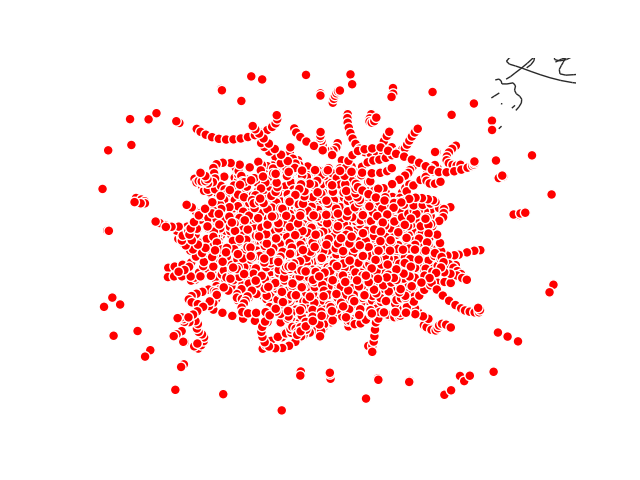

In [ ]:
from grave import plot_network

network = G.copy()

def color_fixed_coord(node_attrs):
    if node_attrs.get('coordinates', True):
        return {'color': 'red'}
    else:
        return {'color': 'black'}

fig, ax = plt.subplots()
plot_network(network, node_style=color_fixed_coord)


# NetworkX plotting

The NetworkX `spring_layout` allows a subset of fixed points - TODO: make that work!

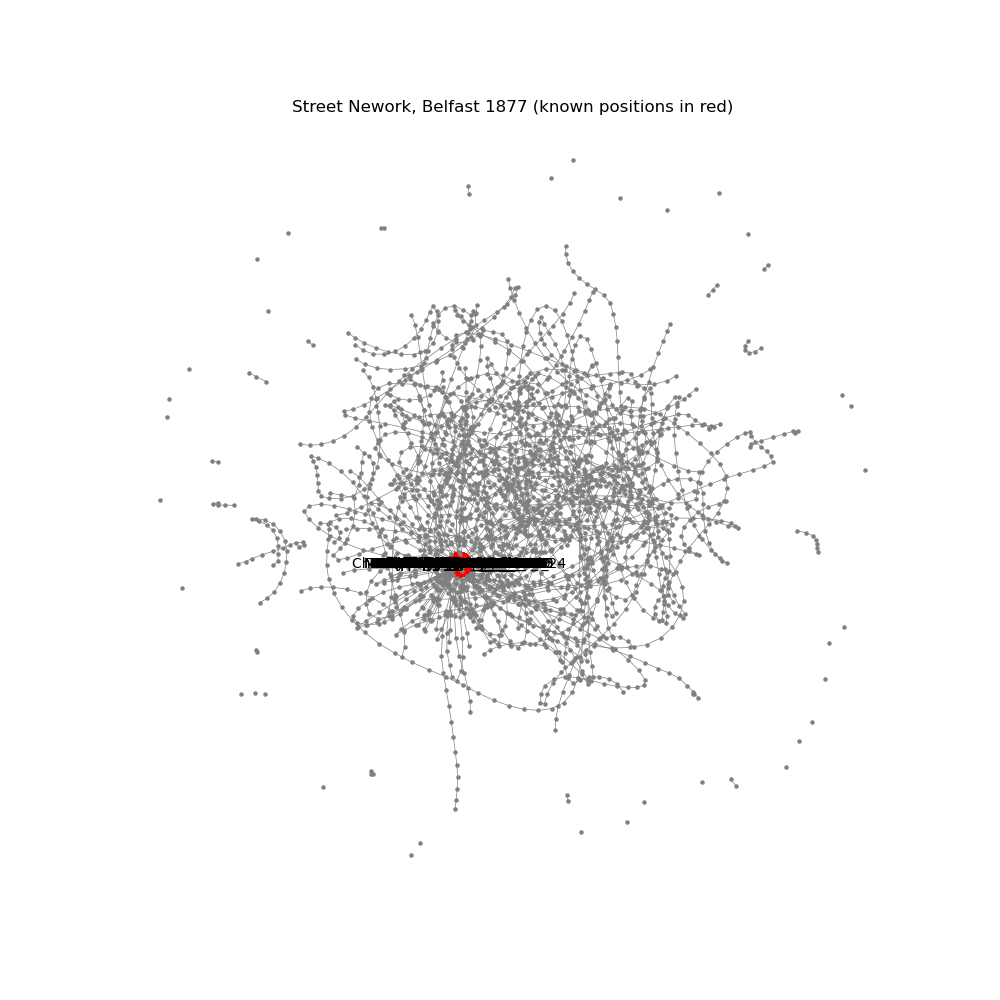

In [ ]:
# create pos attributeas copy of coodinates for proper naming, and to differentiate between nodes with known and derived data later
w = nx.get_node_attributes(G, 'coordinates')
nx.set_node_attributes(G, w, 'pos')

# get only nodes with coordinates
nodes_with_coordinates = [(node, data['coordinates']) for node, data in G.nodes(data=True) if 'coordinates' in data]
fixed_pos = {node: coord for node, coord in nodes_with_coordinates}

# compute center and scale parameters for spring_layout
min_lat, min_lon = 54.57824002300004, -5.87340877594884
max_lat, max_lon = 54.618713694871445, -5.921828013100068

center = ((max_lat + min_lat) / 2, (max_lon + min_lon) / 2)
scale = max(max_lat - min_lat, max_lon - min_lon)

# compute spring layout with fixed positions, center, and scale
spring_pos = nx.spring_layout(G, pos=fixed_pos, fixed=fixed_pos, center=center, scale=scale)

# plot
plt.figure(figsize=(10, 10))

# draw nodes with coordinates (in red and with labels)
nx.draw_networkx_nodes(G, spring_pos, nodelist=[node for node in pos], node_color='red', node_size=300)
nx.draw_networkx_labels(G, spring_pos, labels={node: node for node in pos}, font_size=10, font_color='black')

# draw nodes without coordinates
nx.draw_networkx_nodes(G, spring_pos, nodelist=[node for node in G.nodes if node not in pos], node_color='gray', node_size=5)
nx.draw_networkx_edges(G, spring_pos, edge_color='gray', width=0.5)

plt.title('Street Nework, Belfast 1877 (known positions in red)')
plt.axis('off')
plt.show()

# OSMnx

OSMnx can only be used when all nodes have coordinates. Once I have enough cooordinates I can simplify my graph to only those with coordinates and attempt to use the skipped points as a weighting instead.